In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Exercise 11.

In [2]:
import os

data_path = os.path.join(os.pardir, 'datasets')
celeba_path = os.path.join(data_path, 'celeba')

In [3]:
from tensorflow.keras.preprocessing import image

def load_data(files):
    lst = []
    for file in files:
        img = image.img_to_array(
            image.load_img(celeba_path + '/' + file, target_size=(64, 64)))
        lst.append(img)
    lst = np.array(lst).astype('float32') / 255.
    return lst

In [4]:
files = os.listdir(celeba_path)
files = files[:25000]
dataset = load_data(files)

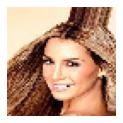

In [5]:
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(dataset[0])
plt.show()

In [6]:
dataset.shape

(25000, 64, 64, 3)

In [7]:
batch_size = 32
dataset = dataset * 2. - 1.
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [8]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        # (-1 ~ 1) to (0 ~ 1)
        image = (image + 1) / 2
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap='binary')
        plt.axis("off")

In [9]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for x_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
        if epoch + 1 <= 5 or (epoch + 1) % 5 == 0:
            plot_multiple_images(generated_images, 8)
            plt.show()

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(8 * 8 * 256, input_shape=[codings_size], 
                       activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Reshape([8, 8, 256]),
    keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='SAME', 
                                 activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='SAME', 
                                 activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='SAME',
                                 activation='tanh'),
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='SAME',
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[64, 64, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='SAME',
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, padding='SAME',
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1654784   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       1638656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1638656   
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 256)       1

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)            

In [13]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy',
            optimizer='rmsprop')

Epoch 1/5


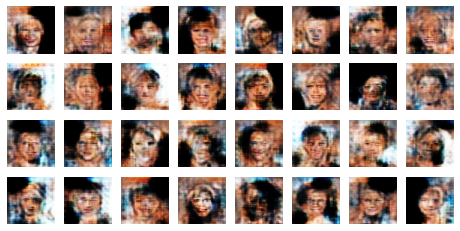

Epoch 2/5


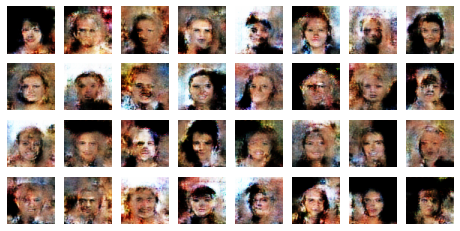

Epoch 3/5


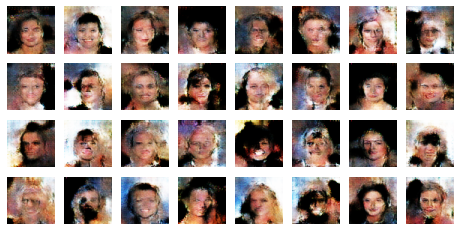

Epoch 4/5


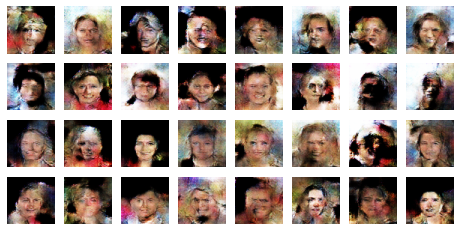

Epoch 5/5


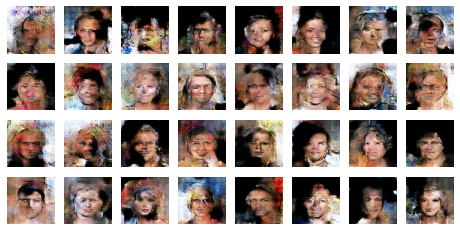

In [14]:
train_gan(gan, dataset, 32, codings_size, 5)

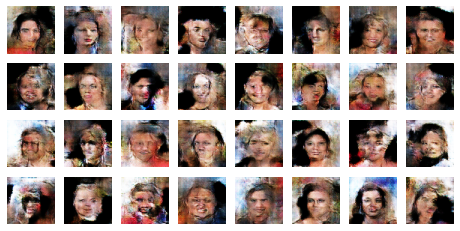

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)